Import necessary **modules**:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import artm

Create **batches** and the **dictionary**:

In [3]:
batch_vectorizer = artm.BatchVectorizer(data_path='data/', data_format='bow_uci',
                                        collection_name='kos', target_folder='data/kos_batches')
dictionary = batch_vectorizer.dictionary

Create the **models**.

In [66]:
topic_names = ['topic_{}'.format(i) for i in range(15)]

model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                      dictionary=dictionary),
                                 artm.SparsityPhiScore(name='SparsityPhiScore'),
                                 artm.SparsityThetaScore(name='SparsityThetaScore'),
                                 artm.TopicKernelScore(name='TopicKernelScore',
                                                       probability_mass_threshold=0.3),
                                 artm.TopTokensScore(name='TopTokensScore', num_tokens=6)],
                         regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                         tau=-0.15),
                                       artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
                                       artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5)])

model_hartm = artm.hARTM(cache_theta=True,
                         scores=[artm.PerplexityScore(name='PerplexityScore',
                                                      dictionary=dictionary),
                                 artm.SparsityPhiScore(name='SparsityPhiScore'),
                                 artm.SparsityThetaScore(name='SparsityThetaScore'),
                                 artm.TopicKernelScore(name='TopicKernelScore',
                                                       probability_mass_threshold=0.3),
                                 artm.TopTokensScore(name='TopTokensScore', num_tokens=6)],
                         regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                                         tau=-0.15),
                                       artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
                                       artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5)])

Train the usual ARTM model with 15 topics.

In [59]:
model_artm.num_document_passes = 1
model_artm.initialize(dictionary=dictionary)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

Train hARTM model with three levels: 5, 10 and 15 topics.

In [60]:
level1 = model_hartm.add_level(num_topics=5)
level1.num_document_passes = 1
level1.initialize(dictionary=dictionary)
level1.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

In [61]:
level2 = model_hartm.add_level(num_topics=10, parent_level_weight=1)
level2.num_document_passes = 1
level2.initialize(dictionary=dictionary)
level2.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

In [62]:
level3 = model_hartm.add_level(num_topics=15, parent_level_weight=1)
level3.num_document_passes = 1
level3.initialize(dictionary=dictionary)
level3.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

Compare various measures for the models:

Sparsity Phi: 0.695 (artm) vs. 0.755 (hartm)
Sparsity Theta: 0.007 (artm) vs. 0.019 (hartm)
Kernel contrast: 0.649 (artm) vs. 0.645 (hartm)
Kernel purity: 0.642 (artm) vs. 0.777 (hartm)
Perplexity: 1720.726 (artm) vs. 1046.298 (hartm)


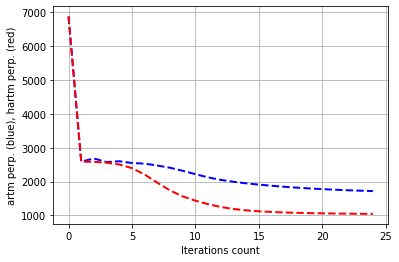

In [63]:
def print_measures(artm, hartm):
    print ('Sparsity Phi: {0:.3f} (artm) vs. {1:.3f} (hartm)'.format(
        artm.score_tracker['SparsityPhiScore'].last_value,
        hartm.score_tracker['SparsityPhiScore'].last_value))

    print ('Sparsity Theta: {0:.3f} (artm) vs. {1:.3f} (hartm)'.format(
        artm.score_tracker['SparsityThetaScore'].last_value,
        hartm.score_tracker['SparsityThetaScore'].last_value))

    print ('Kernel contrast: {0:.3f} (artm) vs. {1:.3f} (hartm)'.format(
        artm.score_tracker['TopicKernelScore'].last_average_contrast,
        hartm.score_tracker['TopicKernelScore'].last_average_contrast))

    print ('Kernel purity: {0:.3f} (artm) vs. {1:.3f} (hartm)'.format(
        artm.score_tracker['TopicKernelScore'].last_average_purity,
        hartm.score_tracker['TopicKernelScore'].last_average_purity))

    print ('Perplexity: {0:.3f} (artm) vs. {1:.3f} (hartm)'.format(
        artm.score_tracker['PerplexityScore'].last_value,
        hartm.score_tracker['PerplexityScore'].last_value))

    plt.plot(range(artm.num_phi_updates),
             artm.score_tracker['PerplexityScore'].value, 'b--',
             range(hartm.num_phi_updates),
             hartm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('artm perp. (blue), hartm perp. (red)')
    plt.grid(True)
    plt.show()

print_measures(model_artm, level3)

Plot the changes in the matrices:

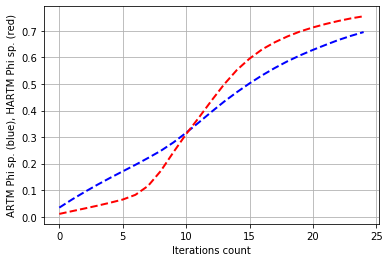

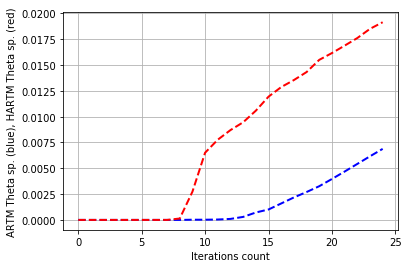

In [64]:
plt.plot(range(model_artm.num_phi_updates),
         model_artm.score_tracker['SparsityPhiScore'].value, 'b--',
         range(level3.num_phi_updates),
         level3.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('ARTM Phi sp. (blue), HARTM Phi sp. (red)')
plt.grid(True)
plt.show()

plt.plot(range(model_artm.num_phi_updates),
         model_artm.score_tracker['SparsityThetaScore'].value, 'b--',
         range(level3.num_phi_updates),
         level3.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('ARTM Theta sp. (blue), HARTM Theta sp. (red)')
plt.grid(True)
plt.show()

See the most popular tokens in hARTM mode:

In [65]:
for topic_name in level3.topic_names:
    print (topic_name + ': ',)
    print (level3.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['people', 'time', 'party', 'years', 'real', 'times']
topic_1: 
['dean', 'democratic', 'edwards', 'kerry', 'candidates', 'primary']
topic_2: 
['elections', 'district', 'race', 'state', 'media', 'seat']
topic_3: 
['campaign', 'john', 'race', 'gop', 'million', 'money']
topic_4: 
['military', 'war', 'public', 'officials', 'americans', 'attacks']
topic_5: 
['war', 'administration', 'issue', 'read', 'wrong', 'united']
topic_6: 
['president', 'bushs', 'white', 'cheney', 'government', 'federal']
topic_7: 
['time', 'country', 'left', 'theyre', 'america', 'decision']
topic_8: 
['iraq', 'american', 'iraqi', 'troops', 'month', 'women']
topic_9: 
['bush', 'report', 'george', 'job', 'states', 'national']
topic_10: 
['administration', 'years', 'asked', 'speech', 'year', 'call']
topic_11: 
['house', 'senate', 'republicans', 'election', 'poll', 'vote']
topic_12: 
['kerry', 'percent', 'voters', 'candidate', 'results', 'party']
topic_13: 
['november', 'electoral', 'governor', 'account', 'voter